In [57]:
%matplotlib inline
import PIL
import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from skimage.filters import gabor
from skimage.feature import local_binary_pattern

In [58]:
import os
import numpy as np
import pandas as pd
from skimage import io, measure, color
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern
from skimage.filters import gabor
from skimage.measure import shannon_entropy
from PIL import Image
from scipy.stats import kurtosis, skew


import cv2
import re

# -------------------- Utility function ------------------------
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")


# -------------------- Load Dataset ------------------------

dataset_dir = "/content/drive/MyDrive/tumor-dataset"

imgs = [] #list image matrix
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
        sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
        len_sub_folder = len(sub_folder_files) - 1
        for i, filename in enumerate(sub_folder_files):
            img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            h, w = gray.shape
            ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
            crop = gray[ymin:ymax, xmin:xmax]

            resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)

            imgs.append(resize)
            labels.append(normalize_label(os.path.splitext(filename)[0]))
            descs.append(normalize_desc(folder, sub_folder))

            print_progress(i, len_sub_folder, folder, sub_folder, filename)

In [59]:
print(f"Number of processed images: {len(imgs)}")


Number of processed images: 4


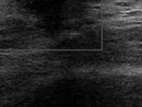

In [63]:

from google.colab.patches import cv2_imshow
cv2_imshow(imgs[3])

In [1]:
!pip uninstall scikit-image -y

!pip install scikit-image==0.18.3



Found existing installation: scikit-image 0.24.0
Uninstalling scikit-image-0.24.0:
  Successfully uninstalled scikit-image-0.24.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 60.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 107.8 MB/s eta 0:00:00
  Created wheel for scikit-image: filename=scikit_image-0.18.3-cp310-cp310-linux_x86_64.whl size=36001462 sha256=57a177d04b0d44a5fdbde319fe616f4dd26b5163920570c690c4e2be03220de8
  Stored in directory: /root/.cache/pip/wheels/9d/55/80/c5bf730bc10906b1518cd6ebc05c87e69d1c46099ebdc9f59f
Successfully built scikit-image


In [2]:
from skimage.feature import greycomatrix, greycoprops
print("Import successful!")


Import successful!


In [33]:
from skimage.feature import greycomatrix, greycoprops

# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[np.pi/4], lvl=256, sym=True, norm=True):

    glcm = greycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label)

    return feature




imgs = [np.array([[0, 1, 2], [1, 2, 3], [2, 3, 4]], dtype=np.uint8),
        np.array([[5, 6, 7], [6, 7, 8], [7, 8, 9]], dtype=np.uint8)]  # Example images

# Example labels for each image (can be any numeric values or categories)
labels = [0, 1]

# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'energy']

glcm_all_agls = []
for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = ['45']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)

columns.append("label")

In [38]:
import pandas as pd
import numpy as np
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls,
                      columns = columns)

glcm_df.head(15)

,dissimilarity_45,correlation_45,homogeneity_45,contrast_45,energy_45,label
0,0.0,1.0,0.0,0.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,1


In [48]:

from google.colab import files
csv_filename = "glcm_features.csv"
glcm_df.to_csv(csv_filename, index=False)

files.download(csv_filename)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
print("Head of the CSV:")
print(df.head())


Head of the CSV:
   dissimilarity_45  correlation_45  homogeneity_45  contrast_45  energy_45  \
0               0.0             1.0             0.0          0.0        0.0   
1               0.0             1.0             0.0          0.0        0.0   

   label  
0      0  
1      1  


In [50]:
print("\nTail of the CSV:")
print(df.tail())


Tail of the CSV:
   dissimilarity_45  correlation_45  homogeneity_45  contrast_45  energy_45  \
0               0.0             1.0             0.0          0.0        0.0   
1               0.0             1.0             0.0          0.0        0.0   

   label  
0      0  
1      1  
